In [23]:
import torchvision
import torch 
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torch.functional as F
import os
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
torch.set_printoptions(sci_mode=False, precision=10)


In [ ]:
#download data og set device
trainset= torchvision.datasets.CIFAR10(root= './data', train=True, download=True)#, transform=transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4665], [0.2023, 0.1994, 0.2919])]))
testset= torchvision.datasets.CIFAR10(root='./data',train=False, download=True)#, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4914, 0.4822, 0.4665], [0.2023, 0.1994, 0.2919])]))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#trainset.classes

Using device: cuda


In [ ]:
#databehandling
x_train=(torch.tensor(trainset.data)/255.0).permute(0,3,1,2)
x_test = (torch.tensor(testset.data)/255.0).permute(0,3,1,2)
y_train=torch.tensor(trainset.targets).long()
y_test=torch.tensor(testset.targets).long()

x_val=x_train[40000:] 
y_val=y_train[40000:]
x_train=x_train[:40000]
y_train=y_train[:40000]

mean= torch.tensor([0.4914, 0.4822, 0.4665]).view(1,3,1,1)
std= torch.tensor([0.2023, 0.1994, 0.2919]).view(1,3,1,1)

x_train=(x_train-mean)/ std

x_val=(x_val-mean)/std

x_test=(x_test-mean)/std


In [ ]:
#dataloader
trainloader=DataLoader(dataset=TensorDataset(x_train, y_train), batch_size=128, shuffle=True) # 1. 100 tilfældige trænningsbilleder 
validationloader= DataLoader(dataset=TensorDataset(x_val, y_val), batch_size=500, shuffle=False) # 2. Validation-billeder
testloader=DataLoader(dataset=TensorDataset(x_test,y_test), batch_size=500, shuffle=False)  # 3. testbilleder


In [ ]:
#parametre funktion
def count_parameters(model):
    params = 0
    for i in model.parameters():
        if i.requires_grad:
            params += i.numel()
    print(f"parametetre i modellen er {params:,}")

In [28]:
def results(model, data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for picture, target in data:       # kører et batch af billeder igennem, og de dertilhørende rigtge labels 
            picture=picture.to(device)
            target=target.to(device)
                                              # vi skriver no grad, fordi vi ikke skal bruge gradienter så det er spil af computing 
            prediction=model(picture)
            pred=prediction.argmax(dim=1) # Her laver modellen et index for den mest sandsynlige klasse der er højst sandsynlighed for hvad billedet er
            correct+=(pred==target).sum().item() # .sum tæller antal true i batchen, .item laver det om til python tal hvori correct tæller antallet af korrekte forudsigelser
            total += target.size(0)  # target.size= batch size(b), og total er samlet antal af billeder evalueret. 
    print(f"accuracy: {correct/total*100:.2f}%")
    return correct/total*100


## Pretrained model and destillation

In [ ]:
#download pretrained model
pretrained_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

Using cache found in C:\Users\frede/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [ ]:
#calculates teacher logits and makes dataloader specifically for distillation
quick_loader = DataLoader(TensorDataset(x_train), batch_size=500, shuffle=False)
teacher_logits = []
for i in quick_loader:
    i = i[0].to(device)
    with torch.no_grad():
        logits = pretrained_model(i)
        teacher_logits.append(logits)
teacher_logits = torch.cat(teacher_logits)

distillationtrainloader = DataLoader(TensorDataset(x_train, y_train, teacher_logits), batch_size=128, shuffle=True)

In [33]:
def distillation(epochs, student, teacher, learning_rate, T, distillation_loss_weight, standard_loss_weight):
    loss_function= nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
    trainlossi = []
    validationlossi = []
    valacc = []
    trainacc = []
    epochi = []
    for epoch in range(epochs):
        student.train()
        runningtrainloss=0.0
        runningvalloss=0.0
        for x_train, y_train, teacher_logit in distillationtrainloader:
            #put det hele til device
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            teacher_logit = teacher_logit.to(device)

            prediction = student(x_train)  # vores egen models prediction

            #student og teacher prediction med temperatur
            teacher_prediction = nn.functional.softmax(teacher_logit / T, dim=-1)
            student_prediction = nn.functional.softmax(prediction / T, dim=-1)

            distillation_loss = torch.sum(teacher_prediction * (teacher_prediction.log() - student_prediction.log())) / student_prediction.size()[0] * (T**2)

            standard_loss = loss_function(prediction, y_train)

            loss = distillation_loss_weight * distillation_loss + standard_loss_weight * standard_loss

            optimizer.zero_grad()
            loss.backward() # backwards pass
            optimizer.step() # opdaterer vægte

            runningtrainloss += loss.item() #loss.item() er loss for hvert batch. runningloss er samlet loss for hele epoch.
        epochi.append(epoch)
        trainlossi.append(runningtrainloss/len(distillationtrainloader))
        scheduler.step()
        student.eval()

        for x, y in validationloader:
            x = x.to(device)
            y = y.to(device)
            with torch.no_grad():
                logits = student(x)
            loss = loss_function(logits, y)
            runningvalloss += loss.item()
            
        validationlossi.append(runningvalloss/len(validationloader))

        print(f"{epoch+1}/{epochs}, trainloss: {runningtrainloss/len(distillationtrainloader)}, valloss: {runningvalloss/len(validationloader)}")
        valacc.append(results(student, validationloader))
        trainacc.append(results(student, trainloader))
        
      #  print(scheduler.get_last_lr()[0])
    return epochi, trainlossi, validationlossi, valacc, trainacc

In [34]:
modelstor = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1), #Første lag af netværket
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1), #Andet lag af netværket
    nn.BatchNorm2d(32),
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1), #Tredje lag af netværket
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1), #Fjerde lag af netværket
    nn.BatchNorm2d(64),
    nn.ReLU(),  
    nn.MaxPool2d(kernel_size=2, stride=2),


    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1), #Femte lag af netværket
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding=1), #Sjette lag af netværket
    nn.BatchNorm2d(128),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2, stride=2),


    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1), #Femte lag af netværket
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1), #Sjette lag af netværket
    nn.BatchNorm2d(256),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=2, stride=2),


    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256,10),
    
    )

modelstor=modelstor.to(device)
optimizer =torch.optim.Adam(modelstor.parameters(), lr=0.001)           # optimerer modellen
loss_function= nn.CrossEntropyLoss()          # Loss-funktion

In [35]:
modellille = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1), #Første lag af netværket
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1), #andet lag af netværket
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(64,10),
    #nn.LogSoftmax(dim=1)
    )

modelille=modellille.to(device)
optimizer = torch.optim.Adam(modellille.parameters(), lr=0.001)           # optimerer modellen
loss_function = nn.CrossEntropyLoss()          # Loss-funktion

In [36]:
count_parameters(modellille)

parametetre i modellen er 20,234


In [37]:
epoch, lossi, valloss, valacc, trainacc = distillation(epochs=90, student=modellille, learning_rate=0.001, teacher=pretrained_model, T=5, distillation_loss_weight=0.8, standard_loss_weight=0.2)

1/90, trainloss: 10.69941809230719, valloss: 1.7530143082141876
accuracy: 39.71%
accuracy: 39.52%
2/90, trainloss: 9.269778754383612, valloss: 1.641965502500534
accuracy: 46.25%
accuracy: 46.53%
3/90, trainloss: 8.805316510672768, valloss: 1.7198703229427337
accuracy: 44.84%
accuracy: 45.90%
4/90, trainloss: 8.51990797268316, valloss: 1.586951094865799
accuracy: 48.16%
accuracy: 49.56%
5/90, trainloss: 8.271908980969803, valloss: 1.6413375973701476
accuracy: 49.47%
accuracy: 50.21%
6/90, trainloss: 8.098852384585543, valloss: 1.5406935930252075
accuracy: 50.88%
accuracy: 52.69%
7/90, trainloss: 7.942014025423092, valloss: 1.52052384018898
accuracy: 52.79%
accuracy: 54.01%
8/90, trainloss: 7.80093158015047, valloss: 1.5218514204025269
accuracy: 53.31%
accuracy: 54.55%
9/90, trainloss: 7.686508411797472, valloss: 1.6002220153808593
accuracy: 51.33%
accuracy: 52.63%
10/90, trainloss: 7.593113565597291, valloss: 1.419664990901947
accuracy: 56.20%
accuracy: 56.94%
11/90, trainloss: 7.485257

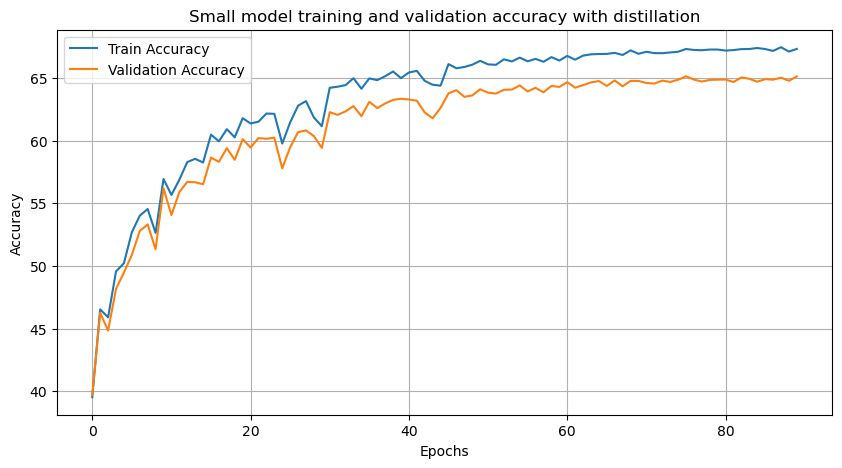

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(epoch, trainacc, valacc)
plt.title("Small model training and validation accuracy with distillation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.grid(True)
plt.show()

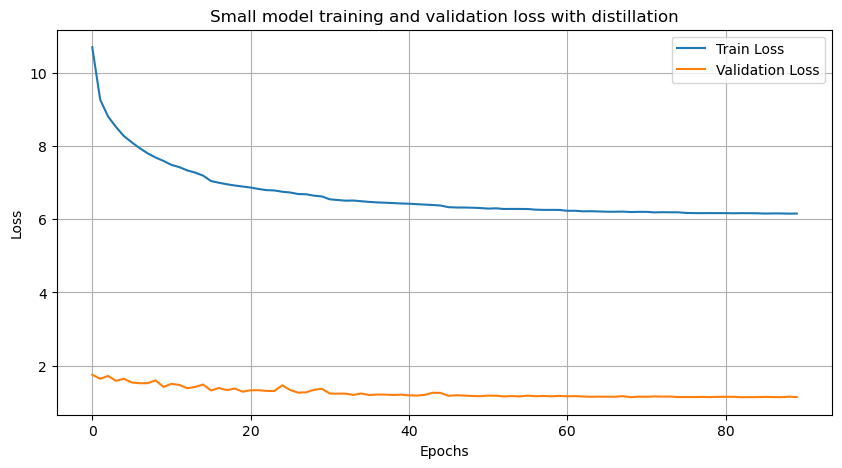

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(epoch, lossi, valloss)
plt.title("Small model training and validation loss with distillation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.grid(True)
plt.show()

In [40]:
results(modellille, testloader)

accuracy: 64.80%


64.8

In [41]:
#i små modeller der underfitter eller store modeller der overfitter kan distillisering bruges til at skubbe modellen i den rigtige retning.
#store modelT=8  distillation_loss_weight=0.8, standard_loss_weight=0.2 training billleder 2000

#lille model valloss = 0.97ca trainloss = 0.9

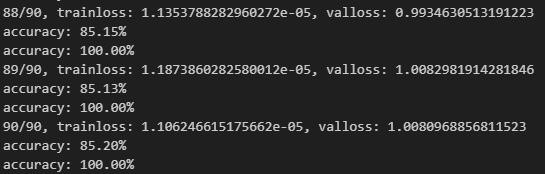

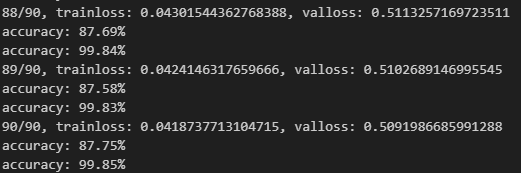